In [1]:
import igraph as ig
import partition_igraph
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *
from itertools import combinations
from sklearn.metrics import adjusted_mutual_info_score as AMI


In [2]:
## DEV
# oNMI = '/work/home/fcthebe/Tools/oNMI/onmi' 

## MAC
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi' 


In [3]:
## calls the oNMI executable, format of inputs: list of lists (communities)
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L


# Dataset

College football dataset from:

[Ref]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799

with corresctions to the labels as described in: https://arxiv.org/pdf/1009.0638

The graph has 115 nodes, 613 edges and after the corrections, there are  12 communities corresponding to Football Conferences.

One of these communities is in fact a group of independent teamswhich we use as surrogate for outlier nodes.
    

In [4]:
with open('football.pkl','rb') as fp:
    cfg = pickle.load(fp)
print(cfg.vcount(), cfg.ecount(), max(cfg.vs['gt'])+1, cfg.is_simple())

115 613 12 True


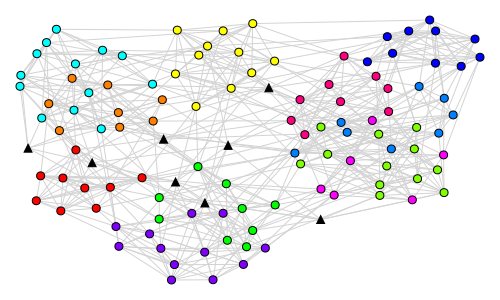

In [5]:
## plot the College Football Graph
## show communities in dfferent colors
## show known outliers as black triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['gt'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['gt']]
for v in cfg.vs:
    if v['gt']==5:
        v['shape']='triangle'
        v['anomaly']=1
        v['color']='black'
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


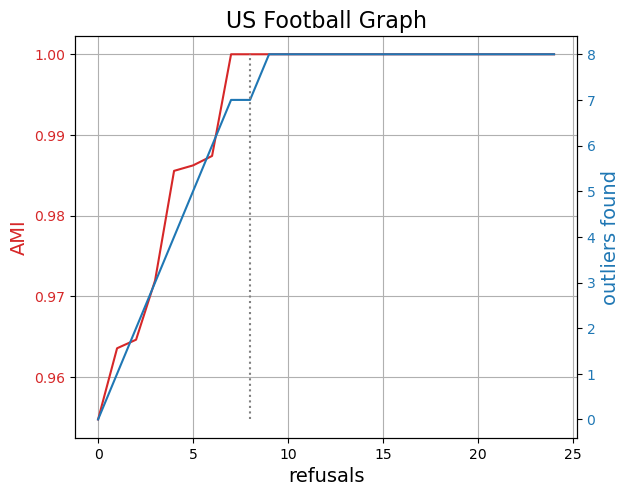

In [6]:
## run ECG and return one of the two "refuse to cluster" scores
ecg = cfg.community_ecg(final='leiden', refuse_score=True)
cfg.vs['ecg'] = ecg.membership

## pick one of the two here:
cfg.vs['refuse_score'] = ecg.refuse_overall
#cfg.vs['refuse_score'] = ecg.refuse_community

L = []
n = cfg.vcount()
for i in range(n-90):
    srt = list(np.argsort(cfg.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),
            sum([cfg.vs[i]['anomaly'] for i in list(np.argsort(cfg.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),0])
df = pd.DataFrame(L, columns=['refusals','AMI','outliers found'])

## plot the above values
## add vertical dashed line at 14, number of ground truth outliers

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('AMI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['AMI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('US Football Graph', fontsize=16)
plt.vlines(8,0,8,color='grey',linestyles='dotted')

plt.show()


In [7]:
## Independent teams (cluster == 5)
Indep = np.where(np.array(cfg.vs['gt'])==5)[0]

## 7 independent are found in the top-8; #42 takes a few more steps after which AMI = 1
print( np.argsort(cfg.vs['refuse_score'])[::-1][:18])
print([x in Indep for x in np.argsort(cfg.vs['refuse_score'])[::-1]][:18])


[ 36  58  82  80  63  97  42  69  59  24  11  28  50  90   0 104  38 112]
[True, True, True, True, True, True, True, False, True, False, False, False, False, False, False, False, False, False]


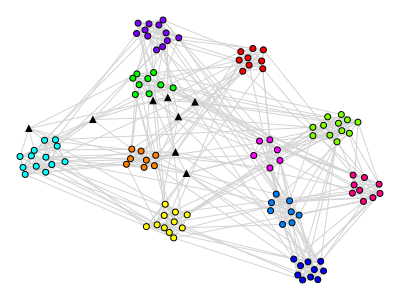

In [8]:
## use ECG weights to show the football graph
cfg.es['weight'] = ecg.W
cfg.vs['size'] = 6
cfg.vs['vertex_labels'] = cfg.vs['name']
ly = cfg.layout_fruchterman_reingold(weights='weight')
ig.plot(cfg, layout=ly, bbox=(0,0,400,300), edge_color='lightgray')


In [9]:
cfg.vs['leiden'] = cfg.community_leiden(objective_function='modularity').membership
GT = mems2comms( [[x] for x in cfg.vs['gt']])
EC = mems2comms([[x] for x in cfg.vs['ecg']])
LD = mems2comms([[x] for x in cfg.vs['leiden']])

print('ECG:',compute_oNMI(EC,GT),AMI(cfg.vs['gt'],cfg.vs['ecg']))
print('Leiden:',compute_oNMI(LD,GT),AMI(cfg.vs['gt'],cfg.vs['leiden']))

print(max(cfg.vs['gt'])+1,max(cfg.vs['ecg'])+1,max(cfg.vs['leiden'])+1)


ECG: 0.928489 0.9547076259706215
Leiden: 0.809101 0.911540196355751
12 12 10


In [10]:
print('ECG oNMI:',compute_oNMI( EC, GT ))
print('Leiden oNMI:',compute_oNMI( LD, GT ))


ECG oNMI: 0.928489
Leiden oNMI: 0.809101


In [11]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [12]:
## EgoSplit, drop size 2 communities
comms_es = EgoSplit(cfg, algo='leiden')
ES = [list(x) for x in comms_es if len(x)>2]    


In [13]:
ctr = Counter([i for j in ES for i in j])
print('EgoSplit oNMI:',compute_oNMI( ES, GT ))

C = sparse.csc_matrix((cfg.vcount(),len(ES)))
C.indices = np.array([int(i) for j in ES for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ES:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()
## Beta
IEF, NIEF, C, Pv, DegPart = CAS(cfg.get_adjacency_sparse(), M)


EgoSplit oNMI: 0.695855


In [14]:
cfg.vs['nief'] = NIEF.max(axis=1).toarray().flatten()
cfg.vs['refuse'] = 1-NIEF.max(axis=1).toarray().flatten()


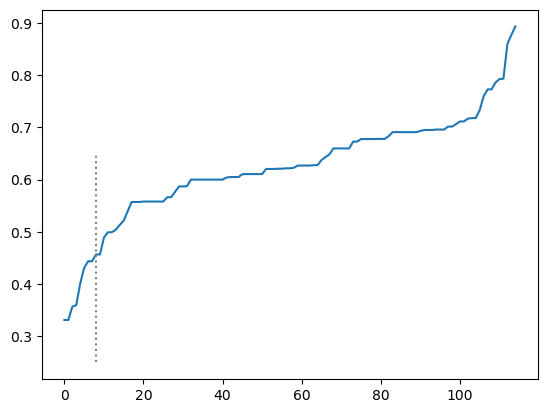

In [15]:
plt.plot(np.sort(cfg.vs['nief']))
plt.vlines(8,.25,.65, linestyles=':',color='grey');


In [16]:
## Independent teams (cluster == 5)
Indep = np.where(np.array(cfg.vs['gt'])==5)[0]

## 7 independent are found in the top-8; #42 takes a few more steps after which AMI = 1
print( np.argsort(cfg.vs['refuse'])[::-1][:18])
print([x in Indep for x in np.argsort(cfg.vs['refuse'])[::-1]][:18])


[ 82  80  58  36  63  42  24  11  97  59  69  90  50 104  55 112   6   9]
[True, True, True, True, True, True, False, False, True, True, False, False, False, False, False, False, False, False]


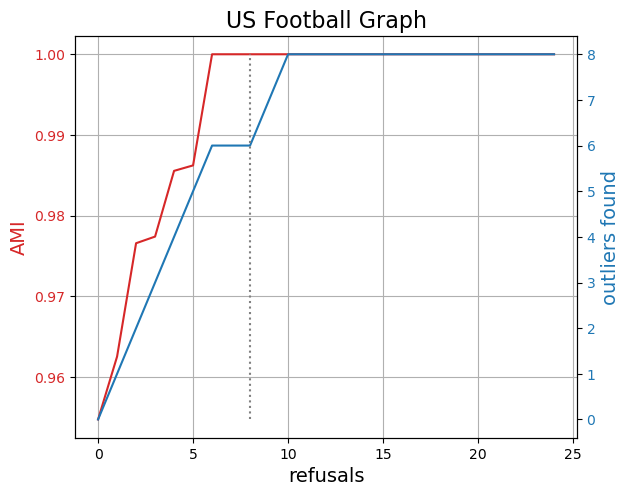

In [17]:
L = []
top = np.argsort(np.array(cfg.vs['refuse']))
n = cfg.vcount()
for i in range(n-90):
    srt = list(top)[:n-i]
    if i>0:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),
            sum([cfg.vs[i]['anomaly'] for i in list(top)[-i:]])])
    else:
        L.append([i, AMI(cfg.vs[srt]['ecg'],cfg.vs[srt]['gt']),0])
df = pd.DataFrame(L, columns=['refusals','AMI','outliers found'])

## plot the above values
## add vertical dashed line at 14, number of ground truth outliers

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('AMI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['AMI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('US Football Graph', fontsize=16)
plt.vlines(8,0,8,color='grey',linestyles='dotted')

plt.show()


In [18]:
np.where((NIEF>=.2).sum(axis=1).flatten() ==2)[1]

array([11, 36, 50, 59, 63, 91])

In [19]:
## 2 and 4
NIEF[11].todense()


matrix([[0.        , 0.12088091, 0.2776509 , 0.        , 0.44371941,
         0.        , 0.        , 0.        , 0.        , 0.05676998,
         0.        , 0.        ]])

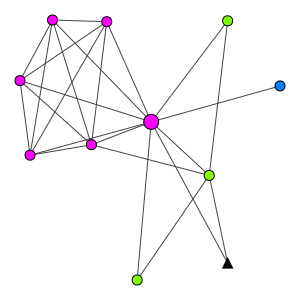

In [20]:
## egonet for 11
sg = cfg.subgraph(cfg.neighborhood(11, order=1))
sg.vs['size'] = 10
sg.vs[sg.vs.find('11').index]['size'] = 15
ig.plot(sg, bbox=(300,300))


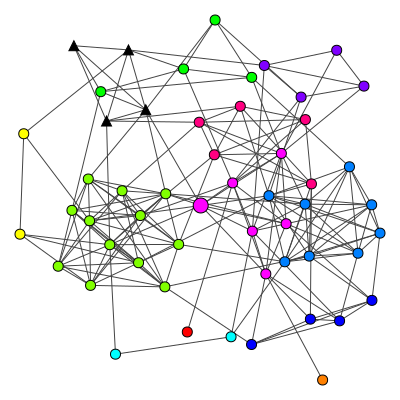

In [21]:
## egonet for 11
sg = cfg.subgraph(cfg.neighborhood(11, order=2))
sg.vs['size'] = 10
sg.vs[sg.vs.find('11').index]['size'] = 15
ig.plot(sg, bbox=(400,400))
